In [44]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [45]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [46]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset

Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0
rice-image-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [47]:
from zipfile import ZipFile

file_name = "/content/rice-image-dataset.zip"
with ZipFile(file_name, 'r') as zip:
    zip.extractall()
print('Done')


Done


In [48]:
import pathlib

data_dir = "../content/Rice_Image_Dataset"  # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir


PosixPath('../content/Rice_Image_Dataset')

In [49]:
import pathlib

data_dir = pathlib.Path("/content/Rice_Image_Dataset")
for category in ["Arborio", "Basmati", "Ipsala", "Jasmine", "Karacadag"]:
    sample_images = list(data_dir.glob(f"{category}/*"))
    print(f"{category}: {len(sample_images)} images")
    if sample_images:
        print(f"Sample path: {sample_images[0]}")


Arborio: 15000 images
Sample path: /content/Rice_Image_Dataset/Arborio/Arborio (9530).jpg
Basmati: 15000 images
Sample path: /content/Rice_Image_Dataset/Basmati/basmati (3589).jpg
Ipsala: 15000 images
Sample path: /content/Rice_Image_Dataset/Ipsala/Ipsala (11787).jpg
Jasmine: 15000 images
Sample path: /content/Rice_Image_Dataset/Jasmine/Jasmine (695).jpg
Karacadag: 15000 images
Sample path: /content/Rice_Image_Dataset/Karacadag/Karacadag (13889).jpg


In [50]:
arborio = list(data_dir.glob('Arborio/*'))[:200]
basmati = list(data_dir.glob('Basmati/*'))[:200]
ipsala = list(data_dir.glob('Ipsala/*'))[:200]
jasmine = list(data_dir.glob('Jasmine/*'))[:200]
karacadag = list(data_dir.glob('Karacadag/*'))[:200]


In [51]:
import tensorflow as tf
from tensorflow import keras


import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.image as img
import PIL.Image as Image
import cv2
import os
import numpy as np


In [52]:
img = cv2.imread(str(arborio[0]))  # Reading an image from the dataset
print(img.shape)  # Prints the shape of the image (e.g., (250, 250, 3))

(250, 250, 3)


In [53]:
df_images = {
    'arborio': arborio,
    'basmati': basmati,
    'ipsala': ipsala,
    'jasmine': jasmine,
    'karacadag': karacadag
}

df_labels = {
    'arborio': 0,
    'basmati': 1,
    'ipsala': 2,
    'jasmine': 3,
    'karacadag': 4
}

In [54]:
X, y = [], []  # X is the image data, y is the labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))  # Reading the image
        resized_img = cv2.resize(img, (224, 224))  # Resizing to 224x224
        X.append(resized_img)  # Appending image to X
        y.append(df_labels[label])  # Appending label to y


In [55]:
X = np.array(X) / 255  # Normalize pixel values to [0, 1]
y = np.array(y)  # Convert labels to numpy array

In [56]:
X_train, X_test_val, y_train, y_test_val = train_test_split(X, y)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val)

In [57]:
print(f"X_train shape: {X_train.shape}")  # Should show (#images, 224, 224, 3)
print(f"y_train shape: {y_train.shape}")  # Should show (#images,)

X_train shape: (750, 224, 224, 3)
y_train shape: (750,)


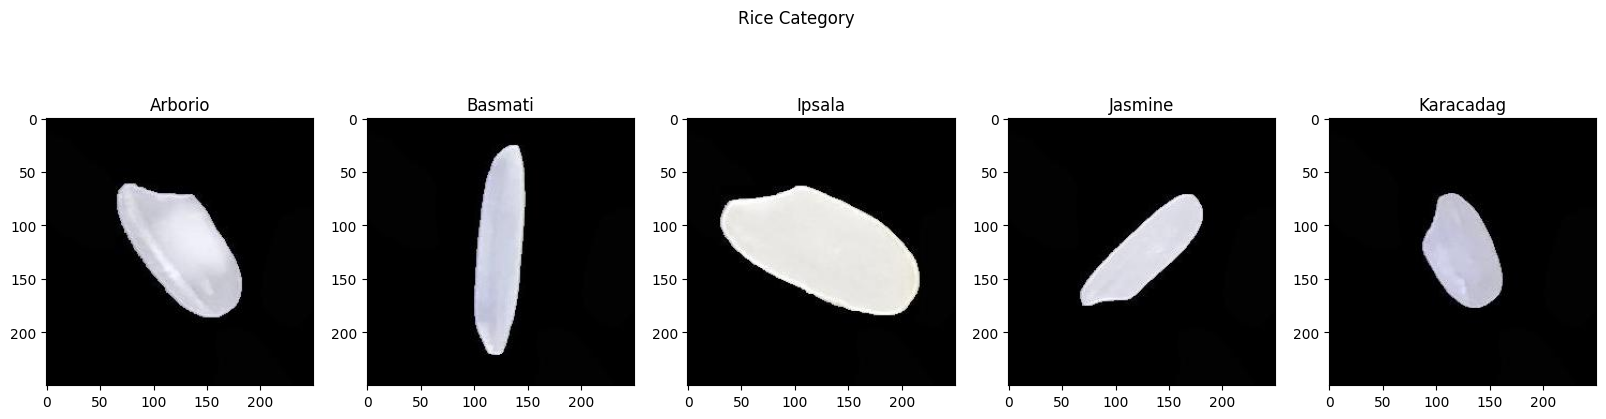

In [58]:
fig, ax = plt.subplots(ncols=5, figsize=(20, 5))
fig.suptitle('Rice Category')

# Use matplotlib.image.imread or cv2.imread instead of img.imread
arborio_image = plt.imread(str(arborio[0])) # or cv2.imread
basmati_image = plt.imread(str(basmati[0])) # or cv2.imread
ipsala_image = plt.imread(str(ipsala[0])) # or cv2.imread
jasmine_image = plt.imread(str(jasmine[0])) # or cv2.imread
karacadag_image = plt.imread(str(karacadag[0])) # or cv2.imread


ax[0].set_title('Arborio')
ax[1].set_title('Basmati')
ax[2].set_title('Ipsala')
ax[3].set_title('Jasmine')
ax[4].set_title('Karacadag')

ax[0].imshow(arborio_image)
ax[1].imshow(basmati_image)
ax[2].imshow(ipsala_image)
ax[3].imshow(jasmine_image)
ax[4].imshow(karacadag_image)

In [76]:
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow import keras

# Load MobileNetV2 feature extractor
mobile_net = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'
mobile_net = hub.KerasLayer(mobile_net, trainable=False)  # Load the model without the last layer

num_labels = 5  # Number of rice classes

# Define the model
model = keras.Sequential([
    keras.layers.InputLayer(shape=(224, 224, 3)),  # Fixed the warning
    keras.layers.Lambda(lambda x: mobile_net(x)),  # Use MobileNetV2 feature extractor
    keras.layers.Dense(num_labels, activation='softmax')  # Output layer for classification
])

# Print model summary
model.summary()



from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Your model layers
x = base_model.output
# Add your additional layers here
# Example:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(5, activation="softmax")(x)  # Assuming 5 rice classes

# Final model
model = Model(inputs=base_model.input, outputs=output_layer)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │           6,405 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,405 (25.02 KB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['acc']
)

In [61]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 350ms/step - acc: 0.3041 - loss: 1.9115 - val_acc: 0.8889 - val_loss: 0.6895
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - acc: 0.8534 - loss: 0.6084 - val_acc: 0.9683 - val_loss: 0.3322
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9416 - loss: 0.3309 - val_acc: 0.9841 - val_loss: 0.2149
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9677 - loss: 0.2240 - val_acc: 0.9841 - val_loss: 0.1602
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9647 - loss: 0.2030 - val_acc: 1.0000 - val_loss: 0.1363
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - acc: 0.9823 - loss: 0.1502 - val_acc: 0.9841 - val_loss: 0.1200
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - acc: 0.9744 - loss: 0.1338 - val_acc: 0.9841 - val_loss: 0.1098
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - acc: 0.9903 - loss: 0.1128 - val_acc: 1.0000 - val_loss: 0.0931
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - acc: 0.98

In [62]:
model.evaluate(X_test,y_test)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 403ms/step - acc: 0.9832 - loss: 0.1215


[0.11150409281253815, 0.9839572310447693]

In [63]:
from sklearn.metrics import classification_report
y_pred = model. predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_bool))

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 956ms/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97        35
           1       1.00      0.97      0.99        39
           2       1.00      1.00      1.00        38
           3       0.98      1.00      0.99        40
           4       0.97      0.97      0.97        35

    accuracy                           0.98       187
   macro avg       0.98      0.98      0.98       187
weighted avg       0.98      0.98      0.98       187



In [65]:
from plotly.offline import iplot, init_notebook_mode
import plotly. express as px
import pandas as pd

init_notebook_mode(connected=True)

acc = pd.DataFrame({ 'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch')
fig.show()

In [66]:
a3 = cv2.imread("../content/Rice_Image_Dataset/Karacadag/Karacadag (18).jpg")
if a3 is None:
    print(f"Error: Could not read image. Check the file path.")
else:
    a3 = cv2.resize(a3, (224, 224))
    a3 = np.array(a3)
    a3 = a3 / 255
    a3 = np.expand_dims(a3, 0)
    pred = model.predict(a3)
    pred = pred.argmax()
    print(pred)
    for i, j in df_labels.items():
         if pred == j:
          print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
4
karacadag


In [67]:
a2 = cv2.imread("../content/Rice_Image_Dataset/Jasmine/Jasmine (10).jpg")
if a2 is None:
    print(f"Error: Could not read image. Check the file path.")
else:
    a2 = cv2.resize(a2, (224, 224))
    a1 = np.array(a2)
    a2 = a2 / 255
    a2 = np.expand_dims(a2, 0)
    pred = model.predict(a2)
    pred = pred.argmax()
    print(pred)
    for i, j in df_labels.items():
         if pred == j:
          print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
3
jasmine


In [68]:
a1 = cv2.imread("../content/Rice_Image_Dataset/Basmati/basmati (10).jpg")
if a1 is None:
    print(f"Error: Could not read image. Check the file path.")
else:
    a1 = cv2.resize(a1, (224, 224))
    a1 = np.array(a1)
    a1 = a1 / 255
    a1 = np.expand_dims(a1, 0)
    pred = model.predict(a1)
    pred = pred.argmax()
    print(pred)
    for i, j in df_labels.items():
         if pred == j:
          print(i)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1
basmati


In [74]:
model.save('my_model.keras')

In [75]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model

# Load MobileNetV2 without top layers
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Your model layers
x = base_model.output
# Add your additional layers here
# Example:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation="relu")(x)
output_layer = Dense(5, activation="softmax")(x)  # Assuming 5 rice classes

# Final model
model = Model(inputs=base_model.input, outputs=output_layer)

# Save the model properly (no Lambda layers)
model.save("my_model.keras")


In [77]:
from google.colab import files
files.download("my_model.keras")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>